In [1]:
%pip install wordcloud regex nltk


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pickle import dump
import seaborn as sns

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [5]:
print(data.shape)
print(f"Spam: {len(data[data['is_spam'] == True])}")
print(f"Ham: {len(data[data['is_spam'] == False])}")

(2999, 2)
Spam: 696
Ham: 2303


In [6]:
# Dropping duplicates

data = data.drop_duplicates()
data = data.reset_index(inplace=False, drop=True)
data.shape

(2369, 2)

In [7]:
print(data.shape)
print(f"Spam: {len(data[data['is_spam'] == True])}")
print(f"Ham: {len(data[data['is_spam'] == False])}")

(2369, 2)
Spam: 244
Ham: 2125


In [8]:
data.iloc[0]['url']

'https://briefingday.us8.list-manage.com/unsubscribe'

In [9]:
# Text processing

def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space
    text = re.sub(r'[^a-z ]', " ", text)

    # Multiple white spaces into one, lowercase, strip leading/trailing whitespace
    text = re.sub(r'\s+', " ", text.lower()).strip()

    # Remove https
    text = re.sub(r'https', '', text)

    return text.split()

data['url'] = data['url'].apply(lambda x: preprocess_text(x))
data.head()

,url,is_spam
0,"[briefingday, us, list, manage, com, unsubscribe]",True
1,"[www, hvper, com]",True
2,"[briefingday, com, m, v, n, i, f]",True
3,"[briefingday, com, n, m, commentform]",False
4,"[briefingday, com, fan]",True


In [10]:
# Lemmatization

download('wordnet')

lemmatizer = WordNetLemmatizer()

download('stopwords')
stop_words = stopwords.words('english')

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

data['url'] = data['url'].apply(lemmatize_text)

data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[briefingday, u, list, manage, com, unsubscribe]",True
1,"[www, hvper, com]",True
2,"[briefingday, com, v, n, f]",True
3,"[briefingday, com, n, commentform]",False
4,"[briefingday, com, fan]",True


In [11]:
data.head()

,url,is_spam
0,"[briefingday, u, list, manage, com, unsubscribe]",True
1,"[www, hvper, com]",True
2,"[briefingday, com, v, n, f]",True
3,"[briefingday, com, n, commentform]",False
4,"[briefingday, com, fan]",True


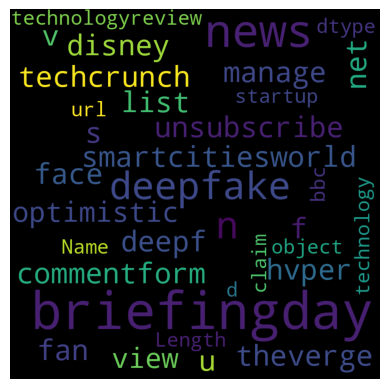

In [12]:
# Word Cloud

wordcloud = WordCloud(width=800, height=800, background_color='black', max_words=1000, min_font_size=12, random_state=42).generate(str(data['url']))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [13]:
# Training and test data

tokens_list = data['url']
tokens_list = [' '.join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)

X = vectorizer.fit_transform(tokens_list).toarray()
y = data['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# SVC model

model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9535864978902954

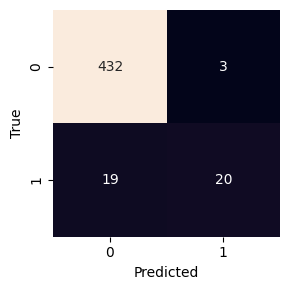

In [15]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(3,3))

sns.heatmap(cm_df, annot=True, fmt='d', cbar=False)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [16]:
# Grid Search

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1.0, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1.0, 10]
    }

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.01, 0.1, 1.0, 10], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1.0, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [17]:
print('Best params:')
print(f'kernel: {grid.best_params_['kernel']}')
print(f'C: {grid.best_params_['C']}')
print(f'degree: {grid.best_params_['degree']}')
print(f'gamma: {grid.best_params_['gamma']}')

Best params:
kernel: rbf
C: 10
degree: 2
gamma: 0.1


In [18]:
# Optimizing model

opt_kernel = grid.best_params_['kernel']
opt_C = grid.best_params_['C']
opt_degree = grid.best_params_['degree']
opt_gamma = grid.best_params_['gamma']

opt_model = SVC(C=opt_C, kernel=opt_kernel, degree=opt_degree, gamma=opt_gamma)
opt_model.fit(X_train, y_train)

y_pred = opt_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9662447257383966

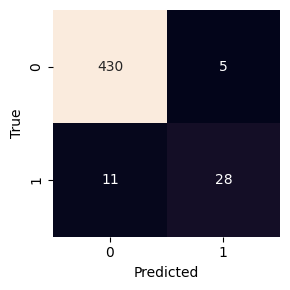

In [19]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(3,3))

sns.heatmap(cm_df, annot=True, fmt='d', cbar=False)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [20]:
dump(opt_model, open('svc_kernelrbf_C10_degree2_gamma0.1.sav', 'wb'))